In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

#### Importando o dataset e o teste cego

In [2]:
dataset = pd.read_csv(r'C:/Users/mathe/Desktop/MATHEUS/UFBA/IC/shalegas-rad/dataset_no_blind.csv', index_col=0)
blind_test = pd.read_csv(r'C:/Users/mathe/Desktop/MATHEUS/UFBA/IC/shalegas-rad/blind_data.csv')

In [3]:
dataset.drop(['Unnamed: 0.1'], axis=1, inplace=True)
blind_test.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
dataset.reset_index(drop=True, inplace=True)

In [5]:
#Acessando o objeto salvo com as 4 layers contendo os indices para acessar no dataset e treinar o algoritmo
with open("kfolds_list","rb") as f:
    k_folds_index= pickle.load(f)

#### Normalizando as amostras

In [6]:
scaler = StandardScaler()
scaler.fit(dataset[['GR','RHOB','ILD_log10']])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [7]:
cv1 = KFold(n_splits=4, shuffle=True, random_state=42)

In [8]:
knn =  vizinho = KNeighborsRegressor()
params = {'n_neighbors':list(np.arange(1,201))}
nearest_neighbor = GridSearchCV(knn,params,scoring='neg_mean_squared_error', cv=cv1, return_train_score=True)
nearest_neighbor.fit(scaler.transform(dataset[['GR','RHOB','ILD_log10']]),dataset.DT)

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [9]:
print(nearest_neighbor.best_estimator_)
print(nearest_neighbor.best_params_)
print(nearest_neighbor.best_score_)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                    weights='uniform')
{'n_neighbors': 17}
-19.907538331809466


In [10]:
df = pd.DataFrame(nearest_neighbor.cv_results_)

In [11]:
df.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
16,0.005497,0.001120,0.028984,0.001210,17,{'n_neighbors': 17},-19.215570,-21.346458,-19.502622,-19.565504,-19.907538,0.841168,1,-17.884967,-17.278898,-17.651499,-17.738224,-17.638397,0.223704
15,0.004248,0.000433,0.027235,0.001298,16,{'n_neighbors': 16},-19.186623,-21.321658,-19.521371,-19.667458,-19.924278,0.825393,2,-17.725425,-17.072295,-17.463977,-17.598793,-17.465122,0.244918
12,0.004497,0.000500,0.026746,0.001928,13,{'n_neighbors': 13},-19.057166,-21.309802,-19.537326,-19.813781,-19.929519,0.841634,3,-17.238444,-16.450888,-16.970906,-17.031836,-16.923019,0.290058
11,0.005247,0.001089,0.023238,0.001479,12,{'n_neighbors': 12},-19.035643,-21.347015,-19.595824,-19.742662,-19.930286,0.859444,4,-16.905346,-16.322189,-16.781458,-16.751047,-16.690010,0.220085
13,0.004491,0.000495,0.027740,0.003901,14,{'n_neighbors': 14},-19.166738,-21.431707,-19.439741,-19.705169,-19.935839,0.884373,5,-17.425083,-16.611129,-17.148354,-17.161421,-17.086497,0.295827


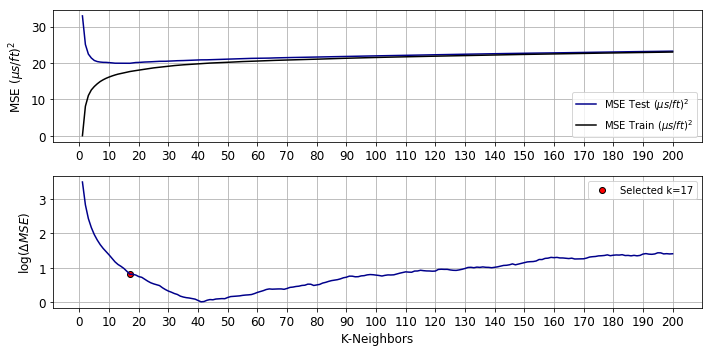

In [15]:
fig, axes = plt.subplots(2, figsize=(10,5))
axes[0].plot(df.sort_values(by='param_n_neighbors').param_n_neighbors, 
             (-(df.sort_values(by='param_n_neighbors')).mean_test_score), 
             c='darkblue', label='MSE Test $(\mu s/ft)^2$')
axes[0].plot(df.sort_values(by='param_n_neighbors').param_n_neighbors, 
             (-(df.sort_values(by='param_n_neighbors')).mean_train_score), 
             c='black', label='MSE Train $(\mu s/ft)^2$')
axes[0].set_ylabel('MSE $(\mu s/ft)^2$')

axes[1].plot(df.sort_values(by='param_n_neighbors').param_n_neighbors, y, c='darkblue')
axes[1].set_xlabel('K-Neighbors')
axes[1].set_ylabel('log($\Delta MSE$)')

axes[1].scatter(df.sort_values(by='param_n_neighbors').param_n_neighbors[16],y[16], 
                c='red',edgecolor='black', label='Selected k=17')
for ax in axes:
    ax.legend()
    ax.grid()
    ax.set_xticks(np.arange(0,200+1,10))

plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

plt.tight_layout()

plt.savefig('log_dif', dpi = 300)

In [13]:
y = np.absolute(np.log((-(df.sort_values(by='param_n_neighbors').mean_test_score)-
                            (-(df.sort_values(by='param_n_neighbors').mean_train_score)))))

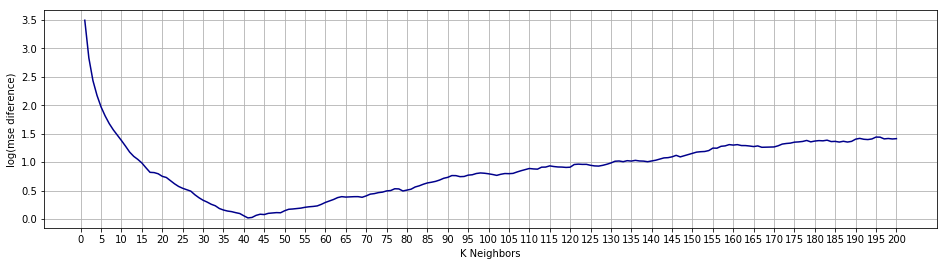

In [14]:
plt.figure(figsize=(16,4))
plt.plot(df.sort_values(by='param_n_neighbors').param_n_neighbors, y, c='darkblue')
plt.xticks(np.arange(0,200+1,5))
plt.xlabel('K Neighbors')
plt.ylabel('log(mse diference)')
plt.grid()

In [15]:
x_blindscale = scaler.transform(blind_test[['GR','RHOB','ILD_log10']])

In [16]:
blind_test['DT_KNN'] = nearest_neighbor.predict(x_blindscale)

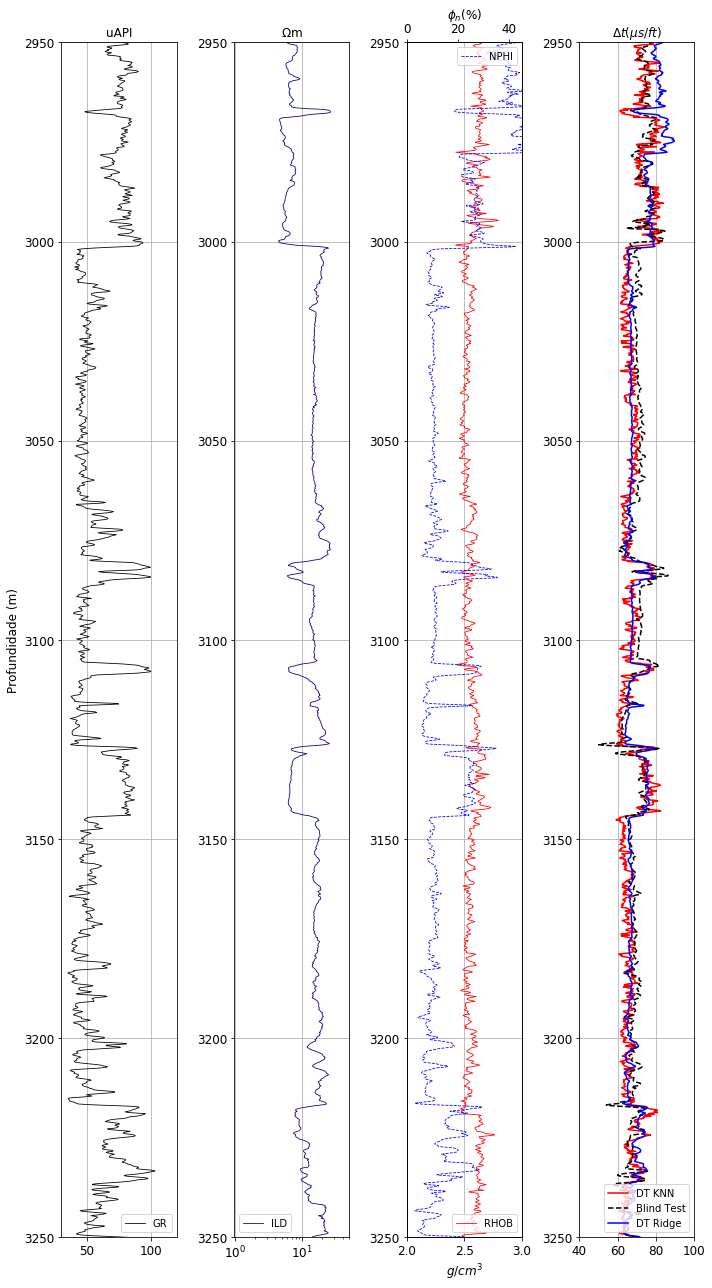

In [17]:
fig, axes = plt.subplots(ncols=4, figsize=(10,18))
axes2 = axes[2].twiny()

axes[0].plot(blind_test.GR, blind_test.DEPT, c='black', label='GR', lw=0.8)
axes[0].set_xlim(30,120)

axes[1].semilogx(blind_test.ILD,blind_test.DEPT, c = 'darkblue', lw=0.8, label='ILD')
axes[1].set_xlim(0,50)

axes[2].plot(blind_test.RHOB, blind_test.DEPT, c = 'red', label='RHOB', lw = 0.8)
axes[2].set_xlim(2,3)

axes2.plot(blind_test.NPHI, blind_test.DEPT, c = 'blue', label = 'NPHI', lw = 0.8, ls='--')
axes2.set_xlim(0,45)
axes2.legend(loc='upper right')
axes2.invert_yaxis()

axes[3].plot(blind_test.DT_KNN.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values, 
             blind_test.DEPT.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values,
             c='red', label='DT KNN')

axes[3].plot(blind_test.DT.loc[(blind_test.DT > 0)].values, 
           blind_test.DEPT.loc[(blind_test.DT > 0)].values, c='black', label='Blind Test', ls='--')
axes[3].plot(blind_test.DT_Ridge.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values, 
             blind_test.DEPT.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values,
             c='blue', label='DT Ridge')
axes[3].set_xlim(40,100)

axes[0].set_title('uAPI')
axes[1].set_title('$\Omega$m')
axes2.set_xlabel('$\phi_n$(%)')
axes[2].set_xlabel('$g/cm^3$')
axes[3].set_title('$\Delta t  (\mu s/ft )$')
axes[0].set_ylabel('Profundidade (m)')


for ax in axes:
    ax.set_ylim(2950,3250)
    ax.invert_yaxis()
    ax.grid()
    ax.legend()
    
axes[2].legend(loc='lower right')
axes[3].legend(loc='lower right')

plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

fig.tight_layout()

In [18]:
blind_test.head()

,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,DEPT,GR,ILD_log10,NPHI,...,Formacao,DT_Ridge,ILD,RHOB_Ridge,DT_KNN,RHOB_KNN,DT_dec_tree,RHOB_dec_tree,DT_r_forest,RHOB_r_forest
0,0,0,0,0,0,0,1968.0936,38.5907,0.486912,14.1915,...,Candeias,74.929268,3.0684,2.417544,68.438229,2.566042,74.760178,2.528123,71.566755,2.523311
1,1,1,1,1,1,1,1968.2460,42.0137,0.495128,12.8958,...,Candeias,74.272424,3.1270,2.447458,69.658694,2.505900,74.760178,2.528123,71.128664,2.529758
2,2,2,2,2,2,2,1968.3984,47.8897,0.503491,11.9561,...,Candeias,73.710652,3.1878,2.484268,82.095318,2.510867,74.760178,2.528123,70.995275,2.535851
3,3,3,3,3,3,3,1968.5508,51.3829,0.516469,13.1344,...,Candeias,74.006718,3.2845,2.487511,82.568606,2.537700,74.760178,2.528123,71.071052,2.538053
4,4,4,4,4,4,4,1968.7032,52.6227,0.530392,14.4057,...,Candeias,74.374604,3.3915,2.479479,82.248765,2.589633,74.760178,2.470055,71.509142,2.505232


In [19]:
blind_test.to_csv(r'C:/Users/mathe/Desktop/MATHEUS/UFBA/IC/shalegas-rad/blind_data.csv')